### Проверка cuda и pytorch


In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.current_device())
print(torch.cuda.device_count())



True
NVIDIA GeForce RTX 2060 SUPER
0
1


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Загрузка данных train/train_df.csv
train_df = pd.read_csv('train/train_df.csv')
test_df = pd.read_csv('test/test_df.csv')
train_df_before_scaling = pd.read_csv('train/train_df.csv')
# Проверка на пропущенные значения
if train_df.isnull().sum().sum() > 0 or test_df.isnull().sum().sum() > 0:
    print("Обнаружены пропущенные значения. Необходима их обработка.")
else:
    print("Пропущенные значения отсутствуют.")

# Стандартизация числовых признаков
features = [f'feature_{i}' for i in range(79)]  # Список названий признаков

scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])
print("Стандартизация числовых признаков выполнена.")


Пропущенные значения отсутствуют.
Стандартизация числовых признаков выполнена.


Статистики до стандартизации:
       feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
mean        9.0   0.193754   0.464293   0.629865  15.928519   3.876401   
std         0.0   0.626654   1.183076   0.482857   5.311422   0.469749   

      feature_6  feature_7  feature_8  feature_9  ...  feature_69  feature_70  \
mean  33.802467   1.211193   1.793847   0.783900  ...    0.142833    0.199545   
std   11.316810   2.234887   1.885131   0.411597  ...    0.131476    0.088724   

      feature_71  feature_72  feature_73  feature_74  feature_75  feature_76  \
mean    0.426543    0.096461         0.0         0.0         0.0    0.297465   
std     0.247388    0.063323         0.0         0.0         0.0    0.311962   

      feature_77  feature_78  
mean    0.030543    0.031207  
std     0.112984    0.115598  

[2 rows x 79 columns]

Статистики после стандартизации:
       feature_0     feature_1     feature_2     feature_3     feature_4  \
mean        0.0  5.465351e-17 -2.26

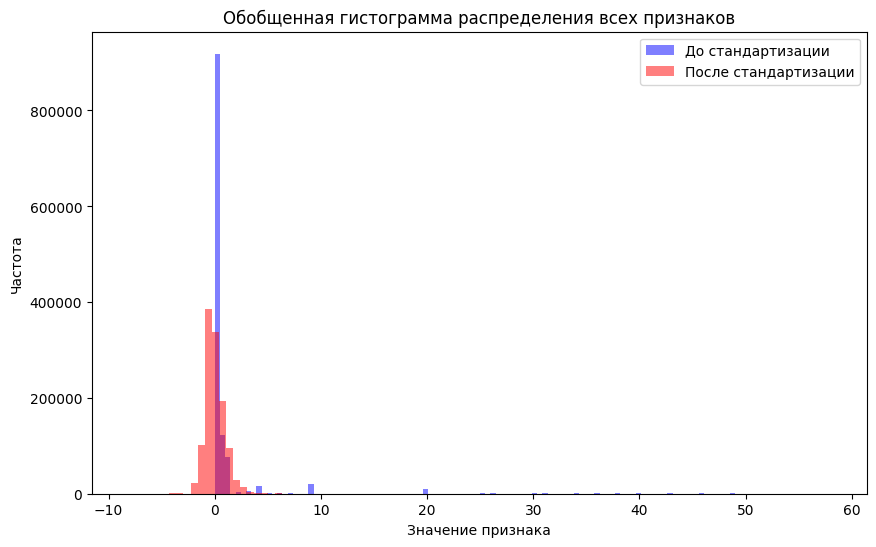

In [3]:
import matplotlib.pyplot as plt
# Расчет средних значений и стандартных отклонений для каждого признака до и после стандартизации
stats_before = train_df_before_scaling[features].describe().loc[['mean', 'std']]
stats_after = train_df[features].describe().loc[['mean', 'std']]

# Вывод средних значений и стандартных отклонений для сравнения
print("Статистики до стандартизации:\n", stats_before)
print("\nСтатистики после стандартизации:\n", stats_after)

import numpy as np

# Объединение всех признаков в один массив для визуализации
all_features_before = np.hstack([train_df_before_scaling[feature].values for feature in features])
all_features_after = np.hstack([train_df[feature].values for feature in features])

print(all_features_before)
print(all_features_after)

# Визуализация
plt.figure(figsize=(10, 6))
plt.hist(all_features_before, bins=100, alpha=0.5, label='До стандартизации', color='blue')
plt.hist(all_features_after, bins=100, alpha=0.5, label='После стандартизации', color='red')
plt.title('Обобщенная гистограмма распределения всех признаков')
plt.xlabel('Значение признака')
plt.ylabel('Частота')
plt.legend()
plt.show()


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(79, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)  # Dropout слой
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Применение Dropout
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Инициализация модели, оптимизатора и функции потерь
model = SimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.MSELoss() # Функция потерь для задачи регрессии
# При необходимости sigmoid в выходном слое и использовании BCELoss
# model.fc3 = nn.Sequential(nn.Linear(64, 1), nn.Sigmoid())
# criterion = nn.BCELoss()
print(model)

SimpleNN(
  (fc1): Linear(in_features=79, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [5]:
from torch.utils.data import TensorDataset, DataLoader
import torch

# Подготовка данных
X_train = torch.tensor(train_df[features].values, dtype=torch.float32)
y_train = torch.tensor(train_df['target'].values, dtype=torch.float32).view(-1, 1) # Изменение формы для совместимости
# Подготовка валидационных данных
X_val = torch.tensor(test_df[features].values, dtype=torch.float32)
y_val = torch.tensor(test_df['target'].values, dtype=torch.float32).view(-1, 1) # Изменение формы для совместимости

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print("ok")


ok


In [6]:
import torch
import numpy as np

def dcg_scores(outputs, targets, k=10):
    _, indices = outputs.topk(k, largest=True, sorted=True)
    targets_sorted_by_outputs = targets.gather(1, indices)
    discounts = torch.log2(torch.arange(k, device=targets.device).float() + 2.0)
    return (targets_sorted_by_outputs / discounts).sum(dim=1)

def ndcg_score(outputs, targets, k=10):
    batch_size = targets.size(0)
    actual_k = min(k, targets.size(1))
    
    if actual_k < 1:
        # Возвращаем 0, если невозможно вычислить NDCG из-за отсутствия данных
        return 0.0

    # Подготавливаем скидки для DCG и IDCG
    discounts = torch.log2(torch.arange(2, actual_k + 2, device=targets.device).float())

    # Вычисляем DCG
    _, indices = outputs.topk(actual_k, dim=1, largest=True, sorted=True)
    targets_sorted_by_outputs = targets.gather(1, indices)
    dcg = (targets_sorted_by_outputs / discounts).sum(dim=1)

    # Вычисляем IDCG
    _, indices = targets.topk(actual_k, dim=1, largest=True, sorted=True)
    ideal_sorted_targets = targets.gather(1, indices)
    idcg = (ideal_sorted_targets / discounts).sum(dim=1)

    # Избегаем деления на 0, заменяя невалидные значения IDCG на 1 (чтобы NDCG было 0)
    idcg[idcg == 0] = 1

    # Вычисляем NDCG
    ndcg = dcg / idcg
    return ndcg.mean().item()



print("ok")


ok


In [7]:
# Перемещаем модель на доступное устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def validate(model, val_loader, criterion):
    model.eval() # Переключаем модель в режим оценки
    running_loss = 0.0
    total_ndcg = 0.0
    with torch.no_grad(): # Отключаем вычисление градиентов
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            total_ndcg += ndcg_score(outputs, labels) * inputs.size(0)
    return running_loss / len(val_loader.dataset), total_ndcg / len(val_loader.dataset)


# Цикл обучения
num_epochs = 7 # Можете настроить количество эпох

for epoch in range(num_epochs):
    model.train()  # Переключаем модель в режим обучения
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Валидация
    val_loss, val_ndcg = validate(model, val_loader, criterion)
    
    print(f'Эпоха {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation NDCG: {val_ndcg:.4f}')

# Сохранение модели после обучения
torch.save(model.state_dict(), 'model.pth')
print("Модель успешно сохранена.")


Эпоха 1/7, Training Loss: 0.0224, Validation Loss: 0.0219, Validation NDCG: 0.0222
Эпоха 2/7, Training Loss: 0.0211, Validation Loss: 0.0216, Validation NDCG: 0.0222
Эпоха 3/7, Training Loss: 0.0207, Validation Loss: 0.0216, Validation NDCG: 0.0222
Эпоха 4/7, Training Loss: 0.0205, Validation Loss: 0.0216, Validation NDCG: 0.0222
Эпоха 5/7, Training Loss: 0.0205, Validation Loss: 0.0215, Validation NDCG: 0.0222
Эпоха 6/7, Training Loss: 0.0202, Validation Loss: 0.0217, Validation NDCG: 0.0222
Эпоха 7/7, Training Loss: 0.0202, Validation Loss: 0.0212, Validation NDCG: 0.0222
Модель успешно сохранена.


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


model_loaded = SimpleNN()

model_loaded.load_state_dict(torch.load('model.pth'))
model_loaded.eval()  # Переключение в режим оценки
print("Модель успешно загружена.")
# Выполните валидацию модели и получите предсказания
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model_loaded(inputs)
        all_preds.extend(outputs.detach().cpu().numpy())
        all_targets.extend(labels.detach().cpu().numpy())

# Переопределение функции расчета метрик, учитывая, что может быть дисбаланс классов
def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

calculate_metrics(np.array(all_targets), np.array(all_preds))




Модель успешно загружена.


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)